This notebook aims to analyze Barabasi network generation algorithm in the context of reproducing GRN-like networks.

Two methods are tested here:

Current implementation of the Barabasi network generation in GRNgene with various an values.

Networkx implementation to verify there was no error in the GRNgene version.

Ultimately we can then modulate some fixed parameters within GRNgene implementation.

# Packages and functions

In [2]:
# Editing mode
%load_ext autoreload
%autoreload 2

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.stats import pearsonr
import GRNgene as gg
import cma
import numpy as np
import pickle as pkl
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# def power_law(x, a):
#     return (a-1) * np.power(x, -a)

def power_law(x, a, b)
    return a * np.power(x, b)

def plot_degrees(
    G: nx.DiGraph,
    plot_fit: bool = False
):
    """
    Plot the total, in- and out- degree distribution of a network and optionally fit a power law.

    Parameters
    ----------
    G : nx.DiGraph
        Directed graph representing the gene regulatory network.
    
    plot_fit : bool, optional (default=False)
        If True, fit and overlay a power-law curve on the degree distribution plot.
        
    Returns
    -------
    None
        Displays the plots and prints the fitted power law parameters if `plot_fit` is True.
    """
    N = G.number_of_nodes()
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    degree_counts = np.unique(degree_sequence, return_counts=True)
    degrees = degree_counts[0]
    counts = degree_counts[1]
    probabilities = counts / N
               
    in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
    in_dmax = max(in_degree_sequence)
    in_degree_counts = np.unique(in_degree_sequence, return_counts=True)
    in_degrees = in_degree_counts[0]
    in_counts = in_degree_counts[1]
    in_probabilities = in_counts / N

    out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
    out_dmax = max(out_degree_sequence)
    out_degree_counts = np.unique(out_degree_sequence, return_counts=True)
    out_degrees = out_degree_counts[0]
    out_counts = out_degree_counts[1]
    out_probabilities = out_counts / N
    
    fig = plt.figure("Degree distribution", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)

    # Total degree
    ax0 = fig.add_subplot(axgrid[0, 0])
    mask = degrees > 0
    ax0.scatter(np.log(degrees[mask]), np.log(probabilities[mask]), marker="o", color="b")
    ax0.set_title("log-log Degree Distribution")
    ax0.set_ylabel("log P(k)")
    ax0.set_xlabel("log Degree k")
    
    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, degrees[degrees > 0], probabilities[degrees > 0])
        ax0.plot(
            np.log(degrees[degrees > 0]),
            np.log(power_law(degrees[degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax0.legend()
    
    # Degree histogram
    ax1 = fig.add_subplot(axgrid[0, 1])
    ax1.bar(degrees, counts)
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Number of Nodes")

    # In-degree
    ax2 = fig.add_subplot(axgrid[1, 0])
    in_mask = in_degrees > 0
    ax2.scatter(np.log(in_degrees[in_mask]), np.log(in_probabilities[in_mask]), marker="o", color="b")
    ax2.set_title("Log-Log In-Degree Distribution")
    ax2.set_ylabel("Log P(k)")
    ax2.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, in_degrees[in_degrees > 0], in_probabilities[in_degrees > 0])
        ax2.plot(
            np.log(in_degrees[in_degrees > 0]),
            np.log(power_law(in_degrees[in_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax2.legend()

    # Degree histogram
    ax2 = fig.add_subplot(axgrid[1, 1])
    ax2.bar(in_degrees, in_counts)
    ax2.set_title("Degree Histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Number of Nodes")
    
    # Out-degree
    ax3 = fig.add_subplot(axgrid[2, 0])
    out_mask = out_degrees > 0
    ax3.scatter(np.log(out_degrees[out_mask]), np.log(out_probabilities[out_mask]), marker="o", color="b")
    ax3.set_title("Log-Log Out-Degree Distribution")
    ax3.set_ylabel("Log P(k)")
    ax3.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, out_degrees[out_degrees > 0], out_probabilities[out_degrees > 0])
        ax3.plot(
            np.log(out_degrees[out_degrees > 0]),
            np.log(power_law(out_degrees[out_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax3.legend()

    # Degree histogram
    ax4 = fig.add_subplot(axgrid[2, 1])
    ax4.bar(out_degrees, out_counts)
    ax4.set_title("Out-Degree Histogram")
    ax4.set_xlabel("Degree")
    ax4.set_ylabel("Number of Nodes")

    fig.tight_layout()
    plt.show()

    if params is not None:
        print(f"Fitted power law parameters: a = {params[0]:.2f}, b = {params[1]:.2f}")

def connect_components_by_hubs(G: nx.DiGraph, hub_bias=3.0, mode='auto', verbose=False):
    """
    Connect disconnected weakly connected components in a directed graph
    by adding edges between hubs (high-degree nodes).

    Parameters
    ----------
    G : nx.DiGraph
        The directed graph (modified in-place).
    hub_bias : float
        Bias factor (> 1 favors high-degree nodes).
    mode : str
        'auto' (default): randomly pick direction
        'out' : source -> target
        'in'  : target -> source
    verbose : bool
        Print progress information.
    """
    W = G.to_undirected()
    components = list(nx.connected_components(W))
    if len(components) <= 1:
        if verbose:
            print("Graph is already weakly connected.")
        return G

    if verbose:
        print(f"Connecting {len(components)} components...")

    # Sort components by size
    components = sorted(components, key=len, reverse=True)

    for i in range(len(components) - 1):
        compA = components[i]
        compB = components[i + 1]

        # Degree dictionary (total degree)
        degA = {n: G.degree(n) for n in compA}
        degB = {n: G.degree(n) for n in compB}

        # Compute hub-biased probabilities
        nodesA, weightsA = zip(*[(n, (d + 1e-3) ** hub_bias) for n, d in degA.items()])
        nodesB, weightsB = zip(*[(n, (d + 1e-3) ** hub_bias) for n, d in degB.items()])
        probA = np.array(weightsA) / np.sum(weightsA)
        probB = np.array(weightsB) / np.sum(weightsB)

        u = np.random.choice(nodesA, p=probA)
        v = np.random.choice(nodesB, p=probB)

        # Determine direction
        if mode == 'auto':
            if random.random() < 0.5:
                G.add_edge(u, v)
            else:
                G.add_edge(v, u)
        elif mode == 'out':
            G.add_edge(u, v)
        elif mode == 'in':
            G.add_edge(v, u)
        else:
            raise ValueError("mode must be 'auto', 'in', or 'out'.")

    return G

def connect_isolated_nodes_to_hubs(G: nx.DiGraph, hub_bias=3.0, mode='out', verbose=False):
    """
    Connect isolated nodes (degree 0) to high-degree nodes using preferential attachment.

    Parameters
    ----------
    G : nx.DiGraph
        The directed graph (modified in-place).
    hub_bias : float
        Bias factor for hub selection (> 1 favors high-degree nodes).
    mode : str
        'out': isolated node -> hub
        'in' : hub -> isolated node
        'auto': random choice between out and in
    verbose : bool
        Whether to print info during processing.
    """
    degrees = dict(G.degree())
    isolated_nodes = [n for n, d in degrees.items() if d == 0]
    hub_candidates = [n for n, d in degrees.items() if d > 0]

    if not isolated_nodes:
        if verbose:
            print("No isolated nodes found.")
        return G

    if not hub_candidates:
        raise ValueError("No nodes with non-zero degree to attach to.")

    # Compute hub-biased probabilities
    weights = [(degrees[n] + 1e-3) ** hub_bias for n in hub_candidates]
    prob = np.array(weights) / sum(weights)

    for iso_node in isolated_nodes:
        hub = np.random.choice(hub_candidates, p=prob)

        if mode == 'out':
            if not G.has_edge(iso_node, hub):
                G.add_edge(iso_node, hub)
                if verbose:
                    print(f"Added edge: {iso_node} → {hub}")
        elif mode == 'in':
            if not G.has_edge(hub, iso_node):
                G.add_edge(hub, iso_node)
                if verbose:
                    print(f"Added edge: {hub} → {iso_node}")
        elif mode == 'auto':
            if random.random() < 0.5:
                if not G.has_edge(iso_node, hub):
                    G.add_edge(iso_node, hub)
                    if verbose:
                        print(f"Added edge: {iso_node} → {hub}")
            else:
                if not G.has_edge(hub, iso_node):
                    G.add_edge(hub, iso_node)
                    if verbose:
                        print(f"Added edge: {hub} → {iso_node}")
        else:
            raise ValueError("mode must be 'out', 'in', or 'auto'.")

    return G

import networkx as nx
import numpy as np
from collections import Counter
import random

def enforce_degree1(G: nx.DiGraph, verbose=False):
    """
    Modify G in-place by removing edges from nodes of the highest degree 
    that has a higher or equal frequency than degree 1, until degree 1 
    is the most frequent in the graph.
    """
    iteration = 0
    while True:
        degrees_dict = dict(G.degree())
        degree_sequence = sorted(degrees_dict.values(), reverse=True)
        degrees_arr, freqs_arr = np.unique(degree_sequence, return_counts=True)

        # Check if degree 1 is most frequent
        max_freq = freqs_arr.max()
        freq_deg1 = freqs_arr[degrees_arr.tolist().index(1)] if 1 in degrees_arr else 0

        if freq_deg1 == max_freq and (freqs_arr > freq_deg1).sum() == 0:
            if verbose:
                print(f"[{iteration}] Degree 1 is now the most frequent.")
            break

        # Find the highest degree with freq ≥ freq of degree 1
        violation_degrees = [deg for deg, freq in zip(degrees_arr, freqs_arr)
                             if freq >= freq_deg1 and deg != 1]
        if not violation_degrees:
            break

        target_degree = max(violation_degrees)
        candidates = [n for n, d in degrees_dict.items() if d == target_degree]
        if not candidates:
            break

        random.shuffle(candidates)
        for node in candidates:
            in_edges = list(G.in_edges(node))
            out_edges = list(G.out_edges(node))
            all_edges = in_edges + out_edges
            if not all_edges:
                continue
            edge = random.choice(all_edges)
            G.remove_edge(*edge)
            if verbose:
                print(f"[{iteration}] Removed edge {edge} from node {node} (deg={target_degree})")
            break  # Reassess after one removal

        iteration += 1

    return G

# Loading E coli network for comparison

In [9]:
filepath = '../data/gnw/Ecoli-full.tsv'
adj_mx = gg.adj_mx_gnw_goldstandard(filepath)
ecoli_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph())

# Get the largest weakly connected component
largest_weakly_cc = max(nx.weakly_connected_components(ecoli_grn), key=len)

# Create the subgraph
ecoli_largest = ecoli_grn.subgraph(largest_weakly_cc).copy()
largest_gnw_properties = gg.network_properties(ecoli_largest)

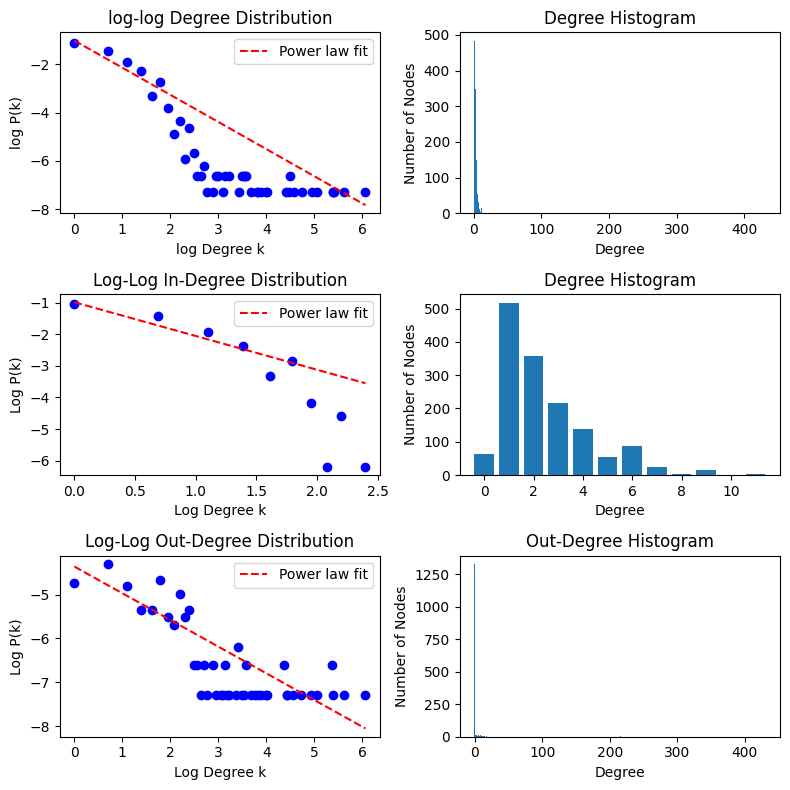

Fitted power law parameters: a = 0.01, b = -0.61


{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

In [10]:
plot_degrees(ecoli_largest, plot_fit=True)
largest_gnw_properties

# Networkx BA

## Node initialisation = 1

/var/tmp/ipykernel_90927/814007992.py:87: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(power_law, in_degrees[in_degrees > 0], in_probabilities[in_degrees > 0])


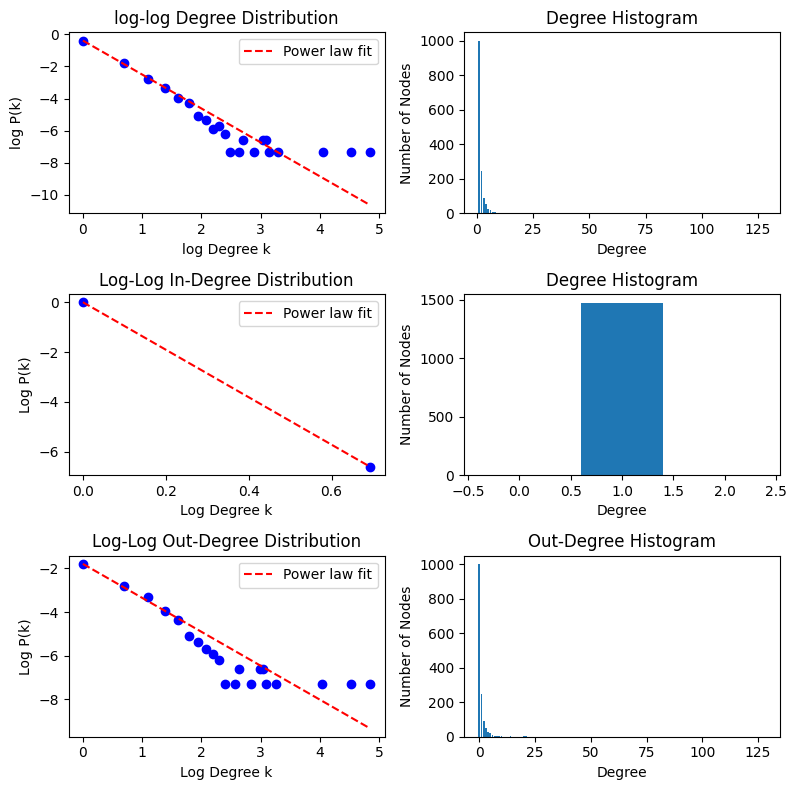

Fitted power law parameters: a = 0.17, b = -1.56


{'avg_clustering': 0.0,
 'avg_degree': 2.001354096140826,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,
         15,  18,  21,  22,  23,  27,  58,  93, 128]),
 'density': 0.0006779654797225021,
 'degree_proba': array([0.67704807, 0.16587678, 0.06025728, 0.03588355, 0.01895735,
        0.01354096, 0.00609343, 0.00473934, 0.00270819, 0.00338524,
        0.00203114, 0.00067705, 0.00067705, 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705]),
 'modularity_value': 0.9214252796321999,
 'nb_edges': 1478,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

In [18]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 1
G_ba = nx.barabasi_albert_graph(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

## Node initialisaiton = 2

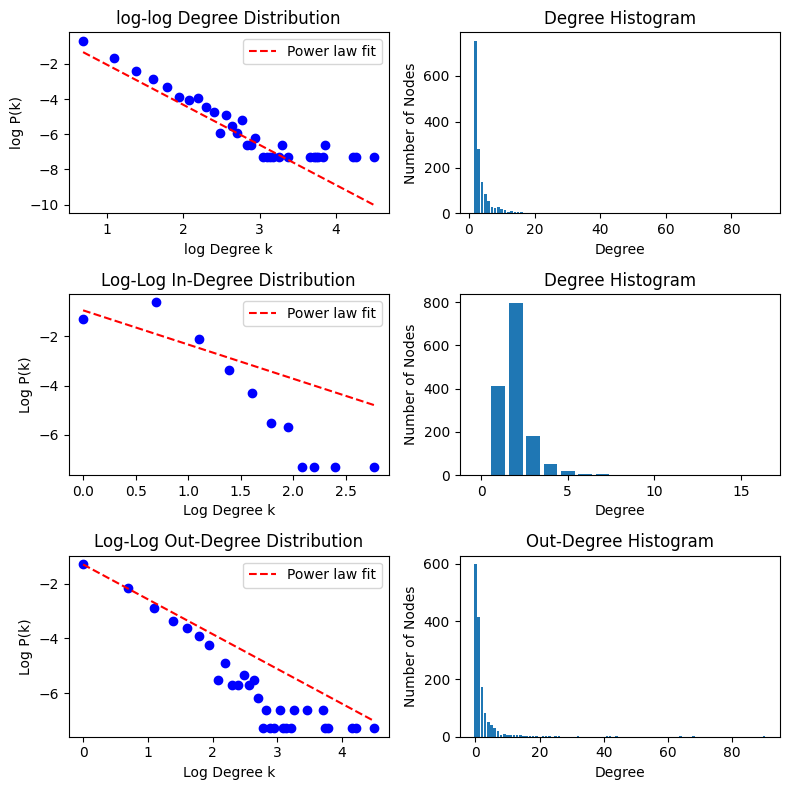

IndexError: index 1 is out of bounds for axis 0 with size 1

In [38]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 2
G_ba = nx.barabasi_albert_graph(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

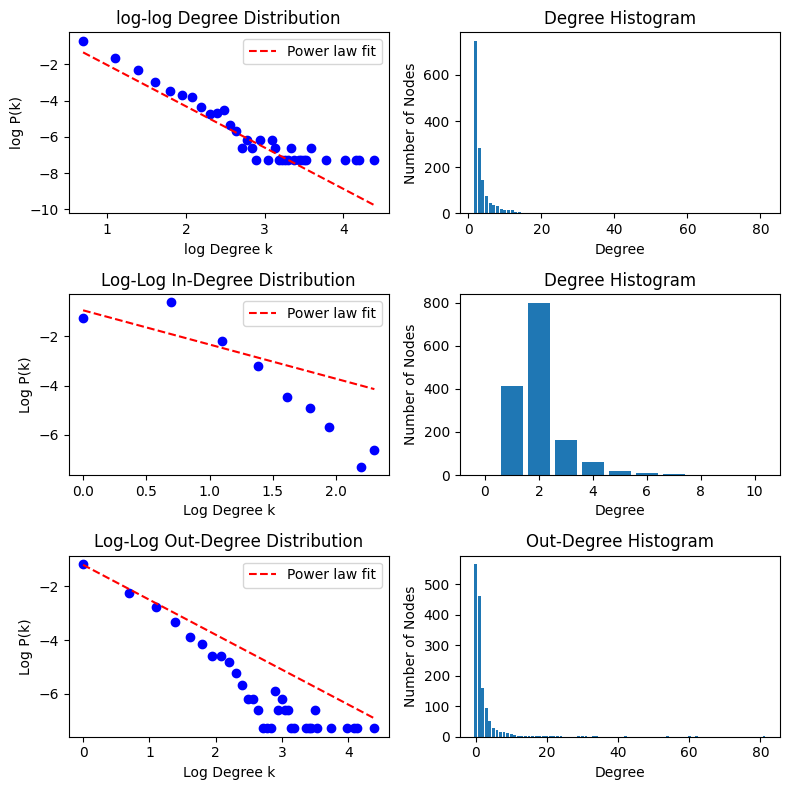

IndexError: index 1 is out of bounds for axis 0 with size 1

In [37]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 2
G_ba = nx.barabasi_albert_graph(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

## Node initialisation = 3

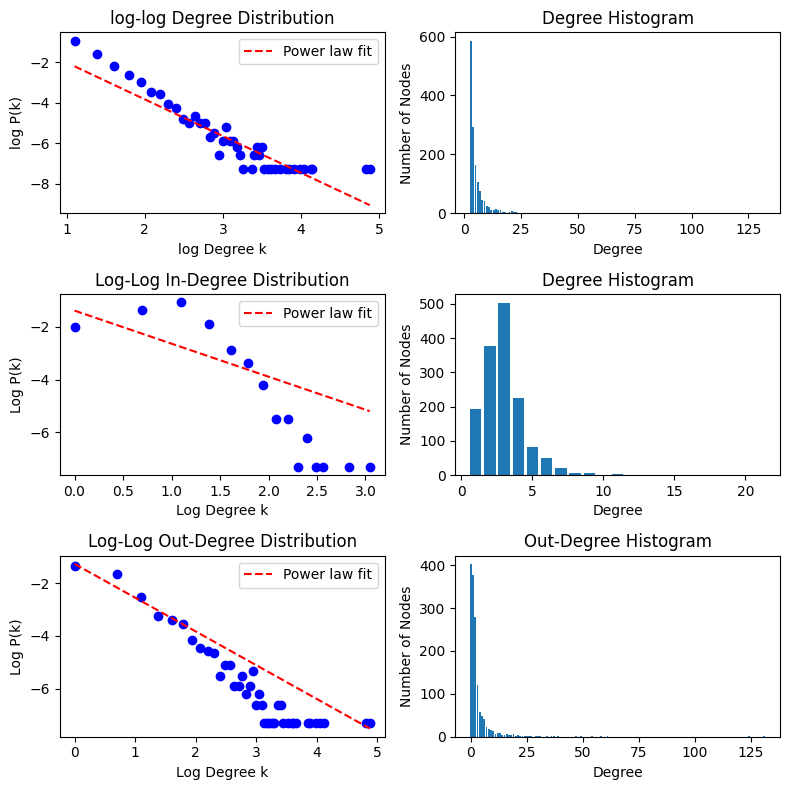

IndexError: index 1 is out of bounds for axis 0 with size 1

In [36]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 3
G_ba = nx.barabasi_albert_graph(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

# GRNgene BA

## Node initialisation = 1

/var/tmp/ipykernel_90927/814007992.py:87: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(power_law, in_degrees[in_degrees > 0], in_probabilities[in_degrees > 0])


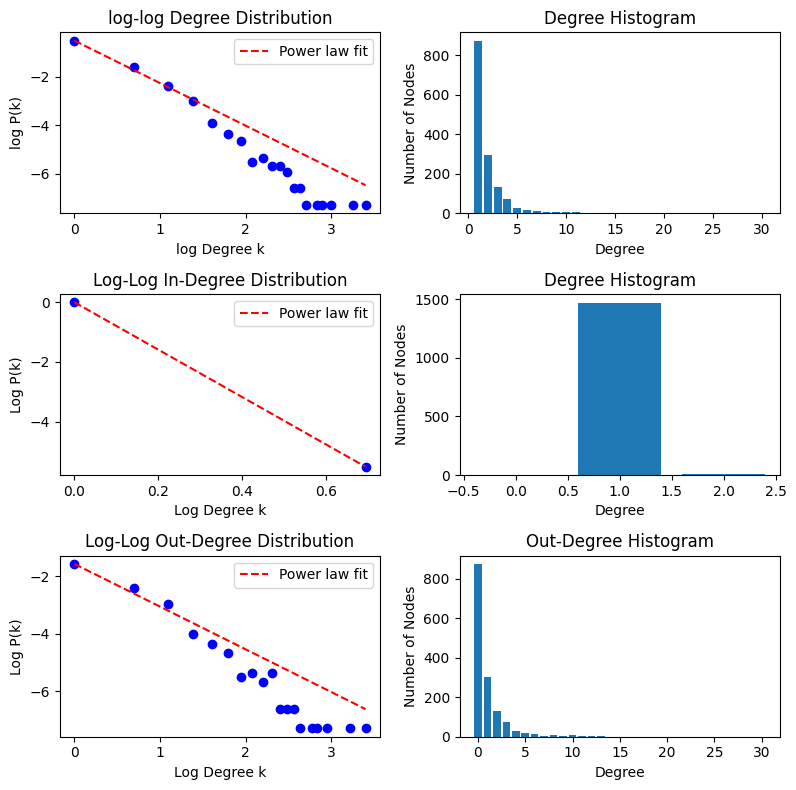

Fitted power law parameters: a = 0.21, b = -1.49


{'avg_clustering': 0.0,
 'avg_degree': 2.0067704807041298,
 'degrees': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
        20, 26, 30]),
 'density': 0.0006798002983415075,
 'degree_proba': array([0.59106297, 0.20176032, 0.09072444, 0.04942451, 0.01963439,
        0.01286391, 0.00947867, 0.00406229, 0.00473934, 0.00338524,
        0.00338524, 0.00270819, 0.0013541 , 0.0013541 , 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705]),
 'modularity_value': 0.9442032318358416,
 'nb_edges': 1482,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

In [26]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 1

G_ba = gg.BarabasiAlbertAlgorithm(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)
grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

## Node initialisation = 2

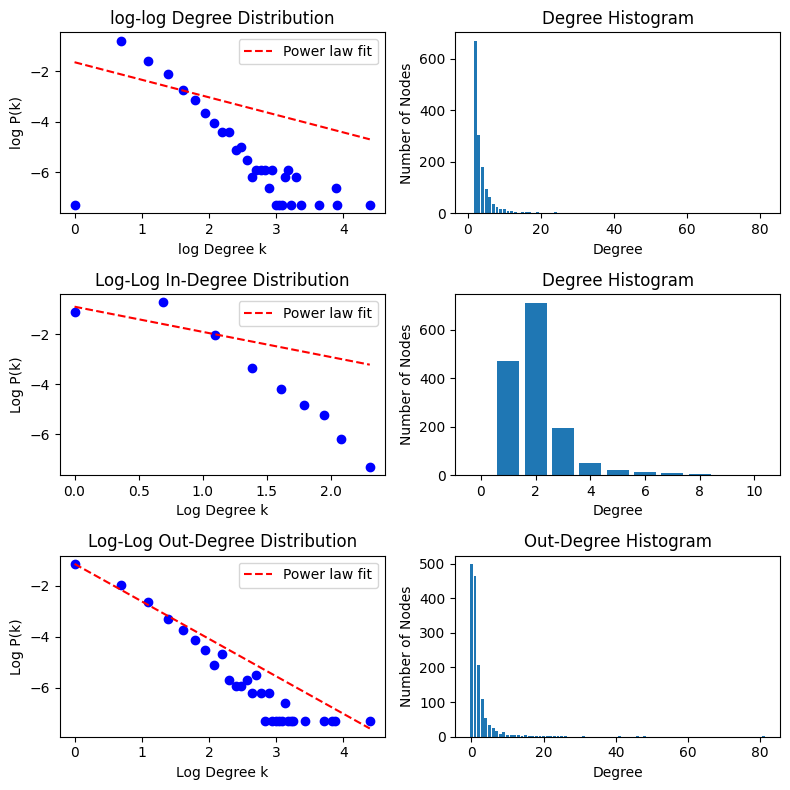

Fitted power law parameters: a = 0.32, b = -1.47


{'avg_clustering': 0.005129019692186965,
 'avg_degree': 4.001354096140826,
 'degrees': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 38, 49, 50, 81]),
 'density': 0.0013554722547902526,
 'degree_proba': array([0.00067705, 0.45294516, 0.20514557, 0.12186865, 0.06431957,
        0.04265403, 0.02572783, 0.01760325, 0.01218687, 0.01218687,
        0.00609343, 0.00677048, 0.00406229, 0.00203114, 0.00270819,
        0.00270819, 0.00270819, 0.0013541 , 0.00270819, 0.00067705,
        0.00067705, 0.00067705, 0.00203114, 0.00270819, 0.00067705,
        0.00203114, 0.00067705, 0.00067705, 0.0013541 , 0.00067705,
        0.00067705]),
 'modularity_value': 0.5230633222750549,
 'nb_edges': 2955,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

In [28]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 2

G_ba = gg.BarabasiAlbertAlgorithm(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)
grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

## Node initialisation = 3

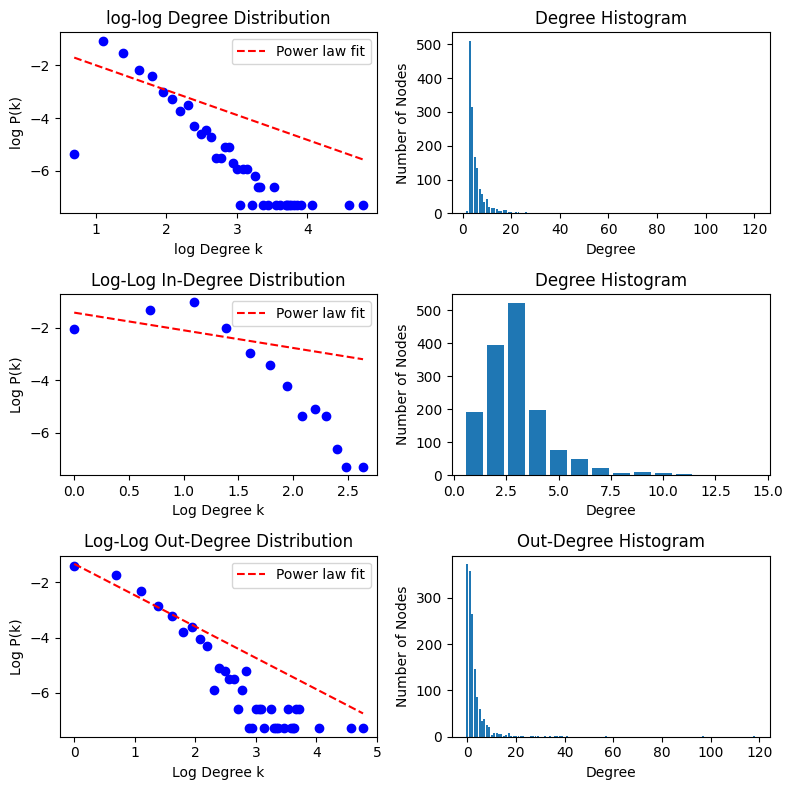

Fitted power law parameters: a = 0.27, b = -1.14


{'avg_clustering': 0.009068219861420744,
 'avg_degree': 5.978334461746784,
 'degrees': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,
         29,  31,  34,  35,  37,  40,  41,  42,  43,  45,  47,  50,  58,
         99, 120]),
 'density': 0.00202518105072723,
 'degree_proba': array([0.00473934, 0.34529452, 0.21259309, 0.11374408, 0.09004739,
        0.04942451, 0.03791469, 0.02369668, 0.02979012, 0.01354096,
        0.01015572, 0.01150982, 0.00880162, 0.00406229, 0.00406229,
        0.00609343, 0.00609343, 0.00338524, 0.00270819, 0.00067705,
        0.00270819, 0.00270819, 0.00067705, 0.00203114, 0.0013541 ,
        0.0013541 , 0.00067705, 0.00067705, 0.0013541 , 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705]),
 'modularity_value': 0.3882770709491958,
 'nb_edges': 4415,


In [29]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 3

G_ba = gg.BarabasiAlbertAlgorithm(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)
grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

## Node initisalisation = 4

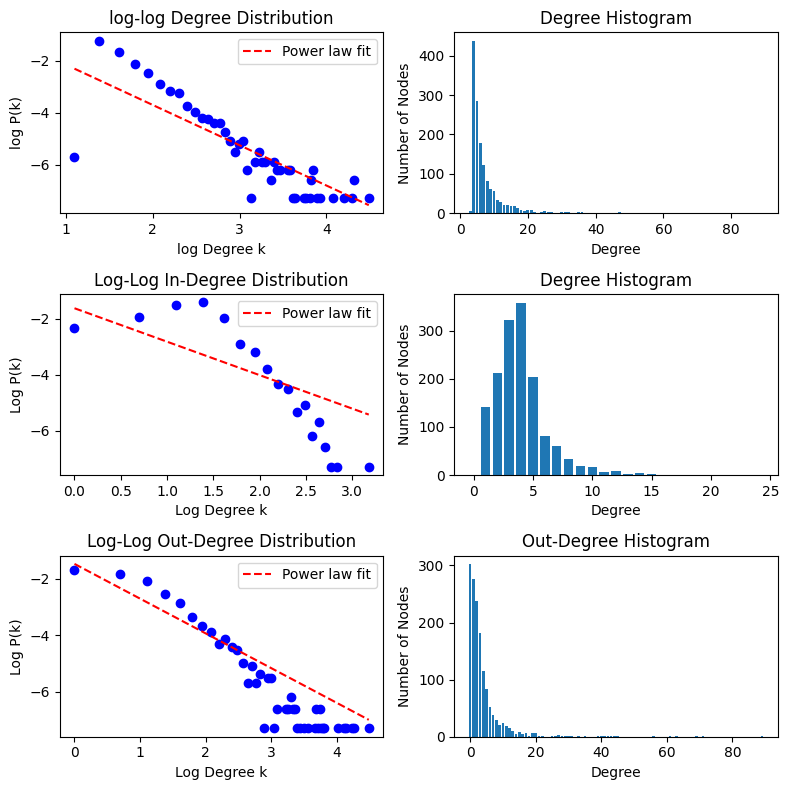

IndexError: index 1 is out of bounds for axis 0 with size 1

In [39]:
n_nodes = largest_gnw_properties['nb_nodes']
node_init = 4

G_ba = gg.BarabasiAlbertAlgorithm(n_nodes, node_init)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)
grn_properties_G_ba = gg.network_properties(G_ba_directed[0])
plot_degrees(G_ba_directed[0], plot_fit=True)
grn_properties_G_ba

# Discussion

A main difference has been identified in the GRNgene implementation and networkx's.

The exact difference and especially the original is yet to be retrieved.

From first inspection, it seems to be the attribution of edges when adding new nodes.